## Build train and test data list

In [1]:
from __future__ import print_function
import keras
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, ZeroPadding2D
from keras.models import Sequential
from keras.models import model_from_json, load_model
from keras import backend as K
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from skimage.feature import blob_log

import os
import glob
import numpy as np
import cv2
from collections import OrderedDict
import pickle

"""Our class activation map module"""
import ClassActMap as cmap

C:\Users\Sarthak\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
## read in all the augmented and noisy images
path = "./Multislice"
folders=os.listdir(path) 
data=[]    #all the images will be stored in this list.
defecttype=[]    #all the defect type corresponding to each image store in this list
defects={'Sw':0,'Mo':1,'W2s2':2,'Vw':3,'Vs2':4,'Ws':5}     # each int represents a defect type

for folder in folders:  #traversing all subfolders(types of defects) in MULTISLICE
    if '.' in folder:   #make sure it will not traverse file like '.DS_store'
        continue
    
    noisy_path = "./Multislice"+"/"+folder+'/'+folder+'_Augmented' 
    filelist = glob.glob(noisy_path+'/*.png')
    data.extend([img_to_array(load_img(fname, grayscale = True)) for fname in filelist])
    defecttype.extend([defects[folder]]*len(filelist))

In [130]:
## there should be 51125 images, each image with size of (64,64,1)
np.array(data).shape

(51125, 64, 64, 1)

In [3]:
#train test split - 80% train and 20% test set

x_train, x_test, y_train, y_test = train_test_split(np.array(data), defecttype, test_size = 0.2, random_state = 28956)

## Train CNN

In [4]:
batch_size = 128
num_classes = 6


# input image dimensions
img_x, img_y = 64, 64
input_shape = (img_x, img_y, 1)

# Normalizing data
x_train = (x_train - np.amin(x_train))/(np.amax(x_train) - np.amin(x_train))
x_test = (x_test - np.amin(x_test))/(np.amax(x_test) - np.amin(x_test))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [253]:
model = Sequential()

##### add layers to CNN model: 
model.add(Conv2D(16,kernel_size=(6,6),strides=(1,1),activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

#model.add(Conv2D(16,(5,5),activation='relu'))
#model.add(Conv2D(16,(3,3),activation='relu'))
#model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(32,(6,6),activation='relu'))
#model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(64,(6,6),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(num_classes,activation='softmax'))
######


model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(lr=0.001),
             metrics=['accuracy'])

In [242]:
"""This is the model with zero padding included"""
model = Sequential()

##### add layers to CNN model: 
model.add(ZeroPadding2D((1,1),input_shape=input_shape))
model.add(Conv2D(8,kernel_size=(7,7),strides=(1,1),activation='relu',input_shape=input_shape))
#model.add(Conv2D(8,(6,6),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(16,(5,5),activation='relu'))
#model.add(Conv2D(16,(5,5),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(32,(3,3),activation='relu'))
#model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(num_classes,activation='softmax'))
######


model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(lr=0.001),
             metrics=['accuracy'])

In [234]:
model = Sequential()

##### add layers to CNN model: 
model.add(ZeroPadding2D((1,1),input_shape=input_shape))
model.add(Conv2D(8,kernel_size=(3,3),strides=(1,1),activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(8,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(16,(3,3),activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(16,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(ZeroPadding2D((1, 1)))          
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(ZeroPadding2D((1, 1)))          
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(64,(1,1),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(num_classes,activation='softmax'))
######


model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(lr=0.001),
             metrics=['accuracy'])

In [254]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self,logs={}):
        self.acc=[]
    
    def on_epoch_end(self,batch,logs={}):
        self.acc.append(logs.get('acc'))

# Change epochs here ---
epochs = 50

history=AccuracyHistory()
        
model.fit(x_train,y_train,
         batch_size=batch_size,
         epochs=epochs,
         verbose=1,
         validation_data=(x_test,y_test),
         callbacks=[history])

Train on 40900 samples, validate on 10225 samples
Epoch 1/50
40900/40900 [==============================] - 144s 4ms/step - loss: 0.9981 - acc: 0.5690 - val_loss: 0.5389 - val_acc: 0.7687
Epoch 2/50
40900/40900 [==============================] - 154s 4ms/step - loss: 0.4519 - acc: 0.8170 - val_loss: 0.3590 - val_acc: 0.8604
Epoch 3/50
40900/40900 [==============================] - 157s 4ms/step - loss: 0.3222 - acc: 0.8685 - val_loss: 0.2842 - val_acc: 0.8826
Epoch 4/50
40900/40900 [==============================] - 152s 4ms/step - loss: 0.2617 - acc: 0.8945 - val_loss: 0.2395 - val_acc: 0.9094
Epoch 5/50
40900/40900 [==============================] - 157s 4ms/step - loss: 0.2340 - acc: 0.9058 - val_loss: 0.2213 - val_acc: 0.9152
Epoch 6/50
40900/40900 [==============================] - 155s 4ms/step - loss: 0.2053 - acc: 0.9185 - val_loss: 0.1962 - val_acc: 0.9264
Epoch 7/50
40900/40900 [==============================] - 154s 4ms/step - loss: 0.1745 - acc: 0.9332 - val_loss: 0.1744 - 

In [204]:
#save the model
model.save("./New_5_9_18_defect_CNN_w_padding2.h5")
model.save_weights("./New_5_9_18_defect_CNN_w_paddingweights2.h5")


"""Or use this to save model"""

#model_json = model.to_json()
#with open("SJ_model.json", "w") as json_file:
#    json_file.write(model_json)
### serialize weights to HDF5
#model.save_weights("SJ_model.h5")

print("Saved model and weights to disk")

Saved model and weights to disk


In [233]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_100 (ZeroPadd (None, 66, 66, 1)         0         
_________________________________________________________________
conv2d_167 (Conv2D)          (None, 64, 64, 8)         80        
_________________________________________________________________
zero_padding2d_101 (ZeroPadd (None, 66, 66, 8)         0         
_________________________________________________________________
conv2d_168 (Conv2D)          (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 32, 32, 8)         0         
_________________________________________________________________
zero_padding2d_102 (ZeroPadd (None, 34, 34, 8)         0         
_________________________________________________________________
conv2d_169 (Conv2D)          (None, 32, 32, 16)        1168      
__________

## Class Activation Map

In [12]:
"""Load CNN Model here"""
model = load_model('New_defect_CNN.h5')

#model = model

#no. of the last conv layer(can be found in model.summary() )
last_conv_layer = -4

image_size = 64, 64

"""Load image file name here"""
image_file = 'SJ_Mo'

CAM_defects = {}

# read in the image file
img = cv2.imread(image_file + '.png', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, image_size, interpolation = cv2.INTER_AREA)
img_i = np.copy(img)
# Preprocessing for Class activation maps
img = cmap.image_preprocessing_cam(img, image_size)

# Getting predictions and target class 
predictions, target_class = cmap.get_predictions(model, img)

softmax_weights = cmap.get_SoftmaxWeights(model)

conv_out = cmap.get_activation_maps(model, img, last_conv_layer)

cam = np.zeros(shape = conv_out.shape[1:3], dtype = np.float32)

for idx, weight in enumerate(softmax_weights[:, target_class]):
    cam += weight * conv_out[idx, :, :]

cam = (cam - np.amin(cam))/(np.amax(cam) - np.amin(cam))
cam[np.where(cam < 0.9)] = 0
cam = cv2.resize(cam, image_size)

# getting defect type
defect_class = cmap.get_defects(defects, target_class)
# finding the defect cordinates
max_coord = blob_log(cam, min_sigma=0.8)
x, y = np.transpose(max_coord)[0:2,:]
coordinates = list(zip(x,y))

# Saving iamge, defect type, coordinate and class activation map in a dictionary to use later
dictionary = OrderedDict()    
dictionary['Image'] = img_i
dictionary['Defect type'] = defect_class
dictionary['Defect coordinates'] = coordinates
dictionary['CAM'] = cam
CAM_defects[image_file] = dictionary

directory = './'+'Pickle_dumps'
    
if not os.path.exists(directory):
    os.makedirs(directory)

pickle.dump(CAM_defects, open(directory + "/CAM_defects.pkl", "wb"))

## Plotting Class Activation Map with image

defect type: Mo
defect coordinates (x, y): [(63.0, 31.0), (46.0, 46.0), (31.0, 31.0)]


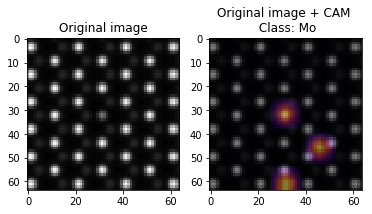

In [13]:
img, defect_type, defect_coordinates, cam = CAM_defects[image_file].values()

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img, cmap = 'gray')
ax1.set_title('Original image')
ax2.imshow(cam, cmap = 'inferno')
ax2.imshow(img, cmap = 'gray', alpha = 0.5)
ax2.set_title('Original image + CAM \n Class: ' + defect_type)

print('defect type:', defect_type)
print('defect coordinates (x, y):', str(defect_coordinates))

## Old Model

In [ ]:
model = Sequential()

##### add layers to CNN model: 
model.add(Conv2D(32,kernel_size=(5,5),strides=(1,1),
                activation='relu',
                input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(64,(5,5),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(1000,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))
######


model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.SGD(lr=0.01),
             metrics=['accuracy'])

In [7]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self,logs={}):
        self.acc=[]
    
    def on_epoch_end(self,batch,logs={}):
        self.acc.append(logs.get('acc'))

history=AccuracyHistory()
        
model.fit(x_train,y_train,
         batch_size=batch_size,
         epochs=epochs,
         verbose=1,
         validation_data=(x_test,y_test),
         callbacks=[history])

Train on 40900 samples, validate on 10225 samples
Epoch 1/50
40900/40900 [==============================] - 283s 7ms/step - loss: 1.6054 - acc: 0.3772 - val_loss: 1.2119 - val_acc: 0.5668
Epoch 2/50
40900/40900 [==============================] - 279s 7ms/step - loss: 0.8499 - acc: 0.6784 - val_loss: 0.6669 - val_acc: 0.7566
Epoch 3/50
40900/40900 [==============================] - 273s 7ms/step - loss: 0.4930 - acc: 0.8068 - val_loss: 0.4115 - val_acc: 0.8365
Epoch 4/50
40900/40900 [==============================] - 271s 7ms/step - loss: 0.3457 - acc: 0.8667 - val_loss: 0.3731 - val_acc: 0.8498
Epoch 5/50
40900/40900 [==============================] - 273s 7ms/step - loss: 0.2912 - acc: 0.8860 - val_loss: 0.2777 - val_acc: 0.8920
Epoch 6/50
40900/40900 [==============================] - 273s 7ms/step - loss: 0.2624 - acc: 0.9003 - val_loss: 0.2308 - val_acc: 0.9099
Epoch 7/50
40900/40900 [==============================] - 272s 7ms/step - loss: 0.2321 - acc: 0.9101 - val_loss: 0.2453 - 

In [2]:
from keras.models import model_from_json, load_model
model = load_model('New_defect_CNN.h5')

In [18]:
type(i)

int

In [6]:
y = (64,64)

In [5]:
y[0]

64

In [9]:
image_file = 'SJ_Mo'

## Still working on this - incorporating coordinate search & making it better and well documented 
## but feel free to optimize
img = cv2.imread(image_file + '.png', cv2.IMREAD_GRAYSCALE)

In [3]:
defects={'Sw':0,'Mo':1,'W2s2':2,'Vw':3,'Vs2':4,'Ws':5}